# Age and Gender Classification

# Preliminaries

In [ ]:
# Necessities
import os
import cv2
import glob
import time
import random
import pandas as pd
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import datasets, models, transforms

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Progress Bar
from tqdm.notebook import tqdm

# File download
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# wandb
!pip install wandb
import wandb
wandb.login()

# Global Configuration

In [ ]:
class config:
  DIRECTORY_PATH = '/content'
  TRAIN_FILE_PATH = os.path.join(DIRECTORY_PATH, 'fairface-label-train.csv')
  VAL_FILE_PATH = os.path.join(DIRECTORY_PATH, 'fairface-label-val.csv')
  MODEL_PATH = os.path.join(DIRECTORY_PATH, 'model.bin')

  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  SEED = 42
  NUM_EPOCHS = 5
  IMAGE_SIZE = 224
  BATCH_SIZE = 32

  LEARNING_RATE = 1e-4
  PRETRAINED = True

In [ ]:
def seed_everything(SEED = config.SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    os.environ['PYTHONHASHSEED']=str(SEED)

# Download Dataset

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive( file_id, name ):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

!unzip -qq fairface-img-margin025-trainval.zip

# Load Dataset

In [ ]:
train_df = pd.read_csv(config.TRAIN_FILE_PATH)
val_df = pd.read_csv(config.VAL_FILE_PATH)

In [ ]:
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [ ]:
# Maximum Value of Age
max(train_df.age)

79

# Dataset Class

In [ ]:
class GenderAgeDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df 
    self.normalize = transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    data = self.df.iloc[index].squeeze()
    file = data.file
    age = data.age
    gender = data.gender == "Female"
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, age, gender

  def preprocess_image(self, img):
    img = cv2.resize(img, (config.IMAGE_SIZE, config.IMAGE_SIZE))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img/255.)
    return img[None]

  def collate_fn(self, batch):
    imgs, ages, genders = [], [], []

    for img, age, gender in batch:
      img = self.preprocess_image(img)
      imgs.append(img)

      age = float((int(age)/79))  # Scaling the age with maximum value
      ages.append(age)

      gender = float(gender)
      genders.append(gender)

    ages, genders = [torch.tensor(x).to(config.DEVICE).float() for x in [ages, genders]]

    imgs = torch.cat(imgs).to(config.DEVICE)

    return imgs, ages, genders

# Create Datasets and DataLoaders

In [ ]:
def get_data():
  """
  Function to obtain the Training and Validation DataLoaders

  Returns:
        train_loader: Training DataLoader
        val_loader: Validation DataLoader

  """

  train = GenderAgeDataset(train_df)
  val = GenderAgeDataset(val_df)

  train_loader = DataLoader(
      train,
      batch_size = config.BATCH_SIZE,
      shuffle = True,
      drop_last = True,
      collate_fn = train.collate_fn
  )

  val_loader = DataLoader(
      val,
      batch_size = config.BATCH_SIZE,
      shuffle = False,
      collate_fn = val.collate_fn
  )

  return train_loader, val_loader

In [ ]:
train_loader, val_loader = get_data()

# Test the DataLoader
img, age, gender = next(iter(train_loader))
print(img.shape, age.shape, gender.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


# Model

In [ ]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def get_model():
  """
  Function to create the model with custom classifier, define loss functions and optimizer

  Returns:
    model: Pretrained Model with custom classifier
    loss_functions: The two loss functions for the tasks
    optimizer: Optimizer for the Neural Network
  """

  # Load Model
  model = models.vgg16(pretrained=config.PRETRAINED)

  # Freeze Model
  for param in model.parameters():
    param.requires_grad = False

  # Overwrite avgpool layer
  model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten()
  )

  # Model Custom Classifier
  class GenderAgeClassifier(nn.Module):
    def __init__(self):
      super(GenderAgeClassifier, self).__init__()  

      self.intermediate = nn.Sequential(
          nn.Linear(2048, 512),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(128, 64),
          nn.ReLU()
      )

      self.age_classifier = nn.Sequential(
          nn.Linear(64, 1),
          nn.Sigmoid()
      )

      self.gender_classifier = nn.Sequential(
          nn.Linear(64, 1),
          nn.Sigmoid()
      )

    def forward(self, x):
      x = self.intermediate(x)
      age = self.age_classifier(x)
      gender = self.gender_classifier(x)

      return gender, age

  # Override model classifier
  model.classifier = GenderAgeClassifier()

  # Loss Functions
  gender_criterion = nn.BCELoss() 
  age_criterion = nn.L1Loss() 
  loss_functions = gender_criterion, age_criterion 

  # Optimizer
  optimizer = optim.Adam(
      model.parameters(), 
      lr = config.LEARNING_RATE
      )
  
  return model.to(config.DEVICE), loss_functions, optimizer

# Engine

In [ ]:
# Training Function
def train_batch(data, model, criterion, optimizer):
  """
    Function to train one batch of Training Data

    Args:
        data: Data for model training
        model: Deep Learning Model
        criterion: Loss Functions
        optimizer: Optimizer
        
    Returns:
        total_loss: Total loss value for the batch
  """
  model.train()

  img, age, gender = data             # Get Data
  optimizer.zero_grad()               # Zero the gradients

  pred_gender, pred_age = model(img)  # Obtain predictions

  # Calculate Loss
  gender_criterion, age_criterion = criterion
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)

  total_loss = gender_loss + age_loss
  total_loss.backward()

  optimizer.step()                    # Update Parameters

  return total_loss

def validate_batch(data, model, criterion):
  """
    Function to validate one batch of Data

    Args:
        data: Data for model valiation
        model: Deep Learning Model
        criterion: Loss Functions
        
    Returns:
        total_loss: Total loss value for the batch
        gender_acc: Accuracy for gender predictions
        age_mae: Mean Absolute Error for age predictions
  """

  model.eval()
  img, age, gender = data

  # Obtain predictions
  with torch.no_grad():
    pred_gender, pred_age = model(img)

  # Calculate Loss
  gender_criterion, age_criterion = criterion
  gender_loss = gender_criterion(pred_gender.squeeze(), gender)
  age_loss = age_criterion(pred_age.squeeze(), age)

  total_loss = gender_loss + age_loss
  
  # Calculate Accuracy
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age - pred_age).float().sum()

  return total_loss, gender_acc, age_mae

# Training

In [ ]:
def run():
  """
    Function to run the model training

    Args:
        path (str): Path of the model

  """

  # Initialize wandb
  run = wandb.init(project = "age-gender-classification")

  # Load model, loss functions, optimizer
  model, criterion, optimizer = get_model()

  # Create empty lists to store metrics
  val_gender_accuracies = []
  val_age_maes = []
  train_losses = []
  val_losses = []

  best_test_loss = 1000
  start = time.time()

  # Training Loop
  for epoch in range(config.NUM_EPOCHS):

      print(f"########## Epoch: {epoch + 1} ##########")

      epoch_train_loss, epoch_test_loss = 0, 0
      val_age_mae, val_gender_acc, ctr = 0, 0, 0
      
      _n = len(train_loader)

      for ix, data in tqdm(enumerate(train_loader), total = len(train_loader)):
          loss = train_batch(data, model, criterion, optimizer)
          epoch_train_loss += loss.item()

      for ix, data in tqdm(enumerate(val_loader), total = len(val_loader)):
          loss, gender_acc, age_mae = validate_batch(data, model, criterion)
          epoch_test_loss += loss.item()
          val_age_mae += age_mae
          val_gender_acc += gender_acc
          ctr += len(data[0])

      val_age_mae /= ctr
      val_gender_acc /= ctr
      epoch_train_loss /= len(train_loader)
      epoch_test_loss /= len(val_loader)

      wandb.log(
          {
              'Train Loss': epoch_train_loss,
              'Val Loss': epoch_test_loss,
              'Val Age MAE': val_age_mae,
              'Val Gender Accuracy': val_gender_acc
          }
      )

      elapsed = time.time()-start
      best_test_loss = min(best_test_loss, epoch_test_loss)
      print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, config.NUM_EPOCHS, time.time()-start, (config.NUM_EPOCHS-epoch)*(elapsed/(epoch+1))))

      info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
      info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
      print(info)

      val_gender_accuracies.append(val_gender_acc)
      val_age_maes.append(val_age_mae)

  torch.save(model.state_dict(), config.MODEL_PATH)
  wandb.finish()

In [ ]:
run()

########## Epoch: 0 ##########


  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

1/5 (790.81s - 3954.05s remaining)
Epoch: 001	Train Loss: 0.556	Test: 0.461	Best Test Loss: 0.4614
Gender Accuracy: 83.93%	Age MAE: 6.15

########## Epoch: 1 ##########


  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

2/5 (1575.28s - 3150.57s remaining)
Epoch: 002	Train Loss: 0.403	Test: 0.452	Best Test Loss: 0.4523
Gender Accuracy: 84.76%	Age MAE: 6.36

########## Epoch: 2 ##########


  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

3/5 (2356.83s - 2356.83s remaining)
Epoch: 003	Train Loss: 0.287	Test: 0.494	Best Test Loss: 0.4523
Gender Accuracy: 84.54%	Age MAE: 6.33

########## Epoch: 3 ##########


  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

4/5 (3140.13s - 1570.06s remaining)
Epoch: 004	Train Loss: 0.201	Test: 0.635	Best Test Loss: 0.4523
Gender Accuracy: 83.74%	Age MAE: 6.47

########## Epoch: 4 ##########


  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

5/5 (3920.50s - 784.10s remaining)
Epoch: 005	Train Loss: 0.159	Test: 0.727	Best Test Loss: 0.4523
Gender Accuracy: 83.56%	Age MAE: 6.33



Train Loss,█▅▃▂▁
Val Age MAE,▁▅▅█▅
Val Gender Accuracy,▃█▇▂▁
Val Loss,▁▁▂▆█
Train Loss,0.15885
Val Age MAE,6.32543
Val Gender Accuracy,0.83559
Val Loss,0.7274


# Testing

In [ ]:
def plot_results(img_path):
  """
  Function to run inference on test data and save the results
  """

  res_path = "/content/result.png"
  
  # Load and preprocess image
  im = cv2.imread(img_path)

  train = GenderAgeDataset(train_df)
  im = train.preprocess_image(im).to(config.DEVICE)

  # Load Model
  model, _, _ = get_model()
  model.load_state_dict(torch.load(config.MODEL_PATH))

  # Obtain Predictions
  gender, age = model(im)
  pred_gender = gender.to('cpu').detach().numpy()
  pred_gender = np.where(pred_gender[0][0]<0.5,'Male','Female')

  pred_age = age.to('cpu').detach().numpy()
  pred_age = int(pred_age[0][0]*79)

  # Plot Image with Predictions
  im = cv2.imread(img_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  plt.title(f"Gender: {pred_gender}    Age: {pred_age}")
  plt.axis('off')

  plt.imshow(im)

  # Save Image
  plt.savefig(res_path)

  # Initialize a new run
  wandb.init(project = "age-gender-classification")

  res = plt.imread(res_path)

  # Log the image
  wandb.log({"Result": [wandb.Image(res)]})

  wandb.finish()

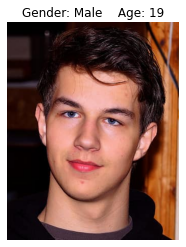

In [ ]:
plot_results("/content/test-1.jpg")

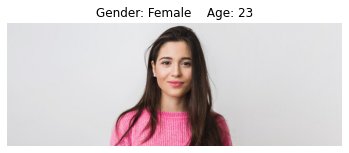

In [ ]:
plot_results("/content/test-2.png")